In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50 ,DenseNet121, EfficientNetB7,VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import ModelCheckpoint , ReduceLROnPlateau , EarlyStopping

In [3]:
# Load the dataset
df = pd.read_csv('sufffle_image.csv')
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID-19', 2: 'Viral Pneumonia'})

In [4]:
# Divide the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)
validate_df,test_df = train_test_split(val_df, test_size=0.50, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [5]:
# Set your IMAGE_SIZE and other parameters
IMAGE_SIZE = (180,180)
batch_size = 16

In [6]:
#Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
      batch_size=batch_size
)
   

Found 27120 validated image filenames belonging to 3 classes.
Found 3390 validated image filenames belonging to 3 classes.


In [7]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

In [8]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

In [9]:
for layer in base_model.layers[:-2]:
    layer.trainable = False

In [10]:
# Adding my custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

In [11]:
# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']         

c:\Users\Iftek\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 12, 12, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 12, 12, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 12, 12, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.000001)
earlystop = EarlyStopping(
    monitor='val_loss',  # You can change this to another metric like 'val_accuracy'
    patience=10,  # Wait for 10 epochs to see if overfitting is resolved
    restore_best_weights=True,
    verbose=1
)
callbacks = [earlystop, learning_rate_reduction]

In [14]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [15]:
epochs = 100

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)
model.save('transfer_VGG.h5')

C:\Users\Iftek\AppData\Local\Temp\ipykernel_21988\4127188724.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
1695/1695 [==============================] - 434s 250ms/step - loss: 0.7223 - accuracy: 0.6621 - val_loss: 0.6177 - val_accuracy: 0.7213 - lr: 0.0010
Epoch 2/100
1695/1695 [==============================] - 466s 275ms/step - loss: 0.6375 - accuracy: 0.7025 - val_loss: 7.2561 - val_accuracy: 0.3421 - lr: 0.0010
Epoch 3/100
1695/1695 [==============================] - 472s 279ms/step - loss: 0.6162 - accuracy: 0.7150 - val_loss: 2.3630 - val_accuracy: 0.4061 - lr: 0.0010
Epoch 4/100
1695/1695 [==============================] - 476s 281ms/step - loss: 0.6023 - accuracy: 0.7257 - val_loss: 1.4787 - val_accuracy: 0.6342 - lr: 0.0010
Epoch 5/100
1695/1695 [==============================] - 469s 276ms/step - loss: 0.5882 - accuracy: 0.7306 - val_loss: 1.2722 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 6/100
1695/1695 [==============================] - 479s 282ms/step - loss: 0.5715 - accuracy: 0.7402 - val_loss: 2.8875 - val_accuracy: 0.3599 - lr: 0.0010
Epoch 7/100
1695/1695 [=====

In [16]:
actual_epochs = len(history.history['loss'])

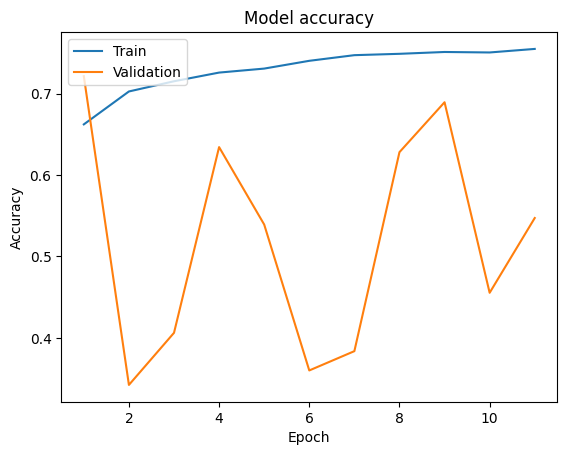

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
numEpochs = range(1,  actual_epochs + 1)
plt.plot(numEpochs,history.history['accuracy'])
plt.plot(numEpochs,history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

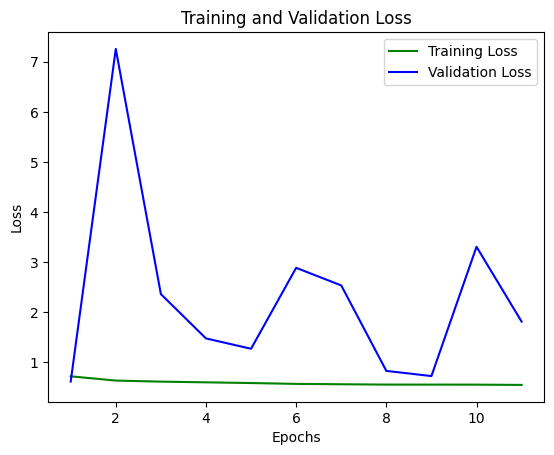

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  actual_epochs + 1)
plt.plot( numEpochs,loss, 'g', label='Training Loss')
plt.plot(numEpochs,val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,filename,category
0,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal
1,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal
2,CS+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
3,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal
4,Datasets\COVID-19_Radiography_Dataset\COVID\im...,COVID-19
...,...,...
3386,Datasets\COVID-19_Radiography_Dataset\COVID\im...,COVID-19
3387,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal
3388,CLAHE\COVID-19_Radiography_Dataset\Viral Pneum...,Viral Pneumonia
3389,CL+MEDIAN\COVID-19_Radiography_Dataset\Viral P...,Viral Pneumonia


In [20]:
nb_samples = test_df.shape[0]

In [21]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(    
    test_df, 
    directory=None,
    x_col='filename',
    y_col='category',
    target_size = IMAGE_SIZE,
    
    class_mode='categorical',
    batch_size = batch_size,
    shuffle = False,
)

Found 3391 validated image filenames belonging to 3 classes.


In [22]:
import numpy as np

In [23]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))
predict

C:\Users\Iftek\AppData\Local\Temp\ipykernel_21988\1469141313.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))


array([[5.8458525e-01, 2.7318275e-01, 1.4223197e-01],
       [1.8858714e-01, 1.2812325e-01, 6.8328959e-01],
       [7.8003502e-01, 1.4687890e-01, 7.3086068e-02],
       ...,
       [1.0534094e-03, 3.9079940e-04, 9.9855584e-01],
       [6.8915069e-01, 1.9317873e-02, 2.9153141e-01],
       [6.8247326e-02, 4.5523268e-01, 4.7651997e-01]], dtype=float32)

In [24]:
test_df['predict_category'] = np.argmax(predict, axis=-1)

In [25]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['predict_category'] = test_df['predict_category'].replace(label_map)

In [26]:
test_df['predict_category'] = test_df['predict_category'].replace({'Normal': 0, 'COVID-19': 1, 'Viral Pneumonia': 2})

In [27]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['predict_category']
    
    # img = load_img(filename, target_size=IMAGE_SIZE)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    # print(third_phrase)

    if 'Normal' in third_phrase:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in third_phrase:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in third_phrase:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [28]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 73.58%
Correct Predictions: 2495 Total Predictions: 3391

Normal Predictions: 698 Accuracy 59.97%
COVID-19 Predictions: 688 Accuracy 63.53%
Viral Pneumonia Predictions: 1109 Accuracy 96.94%


In [29]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    # print(filename)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    if 'Normal' in third_phrase: actual.append(0)
    if 'COVID' in third_phrase: actual.append(1)
    if 'Viral Pneumonia' in third_phrase: actual.append(2)
    # print(f'Actual :{row[1][1]}')   
    # print(f'prediction :{row[1][2]}')   
    pred.append(row[1][2])

C:\Users\Iftek\AppData\Local\Temp\ipykernel_21988\4069215994.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = row[1][0]
C:\Users\Iftek\AppData\Local\Temp\ipykernel_21988\4069215994.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(row[1][2])


In [30]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [31]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64      1164
           1       0.77      0.64      0.69      1083
           2       0.75      0.97      0.85      1144

    accuracy                           0.74      3391
   macro avg       0.73      0.73      0.73      3391
weighted avg       0.73      0.74      0.73      3391



In [32]:
from keras.models import load_model
model.load_weights('transfer_VGG.h5')

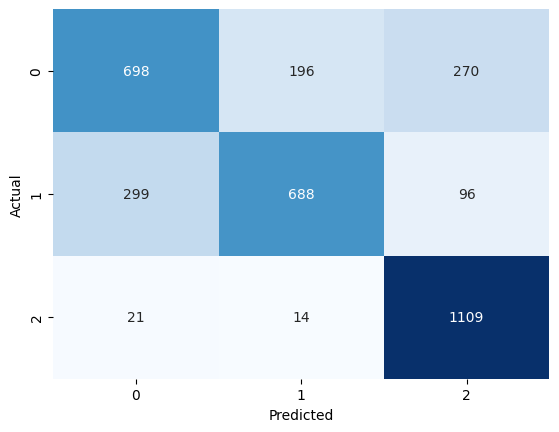

In [33]:
conf_matrix = confusion_matrix(actual, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

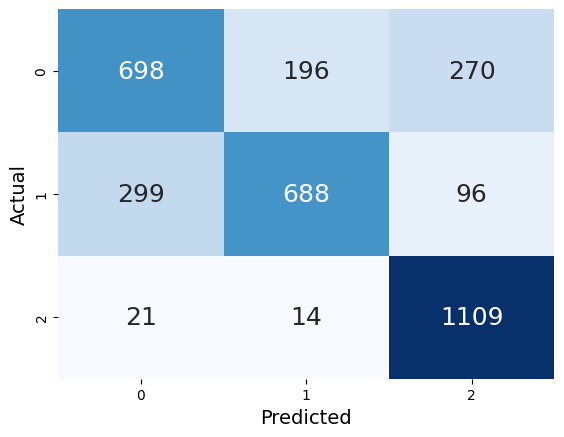

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = [[698, 196, 270], [299, 688, 96], [21, 14, 1109]]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 18})
plt.xlabel('Predicted', fontsize=14)  # Adjust the font size as needed
plt.ylabel('Actual', fontsize=14)  # Adjust the font size as needed
plt.savefig('res50.pdf')
plt.show()